In [1]:
# Import public packages and functions
import os
import pandas as pd
import numpy as np
import sys
import json
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings("ignore")

# inserting the lib folder to the compiler
sys.path.insert(0, './lib')
sys.path.insert(0, './utils/')

import utils_plotting_psd, utils_plotting, utils_psd, utils_io, utils_statistics
pd.options.display.float_format = "{:,.3f}".format

from lib_data import DATA_IO

In [2]:
PATH_CURR              = os.path.abspath(os.curdir)    # current code
PATH                   = (str(Path(PATH_CURR).parent)) # data repository: upper directory where datasets situated

# 1. DATA LOAD

In [4]:
#####################################################################
# STEP 1: Loading PSD Data
#####################################################################

# load ECOG-PSD dataframe
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")

# concat all different dyskinesia severity dataframe into single dataframe
ECOG_PSD = pd.DataFrame()
for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD = pd.concat([ECOG_PSD, ECOG_PSD_controlateral[severity]], ignore_index=True)

# assign severity scores
ECOG_PSD["severity"] = ECOG_PSD['dyskinesia_arm']
ECOG_PSD.loc[(ECOG_PSD['severity'] != "none"), 'severity']                                        = 'LID'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] < 30)  & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_noDOPA'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] >= 30) & (ECOG_PSD['severity'] == "none"), 'severity'] = 'noLID_DOPA'


# arrange the dataframe
ECOG_PSD['hemisphere'] = ECOG_PSD['ECoG_hemisphere']
ECOG_PSD['channel']    = ECOG_PSD['ECoG_channel']
# create a unique channel identifier
ECOG_PSD["channel_id"] = ECOG_PSD["patient"] + "_" + ECOG_PSD["hemisphere"] + "_" + ECOG_PSD["channel"]

ECOG_PSD = ECOG_PSD[['patient', "channel_id", 'severity',
                     'pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean',
                     'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean', 
                     'post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']]

features = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean',
            'pre_event_beta_high_mean','pre_event_gamma_mean',
            'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean',
            'event_beta_high_mean','event_gamma_mean', 
            'post_event_theta_mean', 'post_event_alpha_mean',
            'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']

In [5]:
print("NoLID NoDOPA patients : " + str(ECOG_PSD_controlateral["noLID_noDOPA"].patient.nunique()))
print("NoLID DOPA patients   : " + str(ECOG_PSD_controlateral["noLID_DOPA"].patient.nunique()))
print("LID patients          : " + str(ECOG_PSD_controlateral["LID"].patient.nunique()))

NoLID NoDOPA patients : 10
NoLID DOPA patients   : 9
LID patients          : 8


# 2. LME

In [7]:
dataset_noLIDnoDOPA_vs_noLIDDOPA = ECOG_PSD[ECOG_PSD.severity!="LID"].copy()
dataset_noLIDnoDOPA_vs_LID       = ECOG_PSD[ECOG_PSD.severity!="noLID_DOPA"].copy()
dataset_noLIDDOPA_vs_LID         = ECOG_PSD[ECOG_PSD.severity!="noLID_noDOPA"].copy()

dataset_noLIDnoDOPA_vs_noLIDDOPA.severity = dataset_noLIDnoDOPA_vs_noLIDDOPA.severity.map({'noLID_noDOPA': 0, 'noLID_DOPA': 1})
dataset_noLIDnoDOPA_vs_LID.severity       = dataset_noLIDnoDOPA_vs_LID.severity.map({'noLID_noDOPA': 0, 'LID': 1})
dataset_noLIDDOPA_vs_LID.severity         = dataset_noLIDDOPA_vs_LID.severity.map({'noLID_DOPA': 0, 'LID': 1})
                  
dataset_noLIDnoDOPA_vs_noLIDDOPA.reset_index(drop=True, inplace=True)
dataset_noLIDnoDOPA_vs_LID.reset_index(drop=True, inplace=True)
dataset_noLIDDOPA_vs_LID.reset_index(drop=True, inplace=True)

In [8]:
def built_nested_lme_and_fit(dataset, feature):
    
    import statsmodels.formula.api as smf
    
    model   = smf.mixedlm(formula    = f"{feature} ~ severity",
                          data       = dataset, 
                          groups     = dataset["patient"], 
                          vc_formula = {"channel": "0 + C(channel_id)"})  # random intercept per channel
    result  = model.fit()

    coef    = result.fe_params["severity"]
    p_value = result.pvalues["severity"]
    std_err = result.bse["severity"]
    z_stat  = coef/std_err
    return [coef, p_value, z_stat]

## 2.1 NoLID-NoDOPA vs noLID-DOPA

In [10]:
lme_results = []
dataset     = dataset_noLIDnoDOPA_vs_noLIDDOPA
for feature in features:
    lme_results.append(built_nested_lme_and_fit(dataset, feature))

lme_noLIDnoDOPA_vs_noLIDDOPA                     = pd.DataFrame(data=lme_results, columns=["coefficient", "p_value", "z_stat"])
lme_noLIDnoDOPA_vs_noLIDDOPA["feature"]          = features
lme_noLIDnoDOPA_vs_noLIDDOPA["reference_group"]  = "noLID_noDOPA"
lme_noLIDnoDOPA_vs_noLIDDOPA["comparison_group"] = "noLID_DOPA"
lme_noLIDnoDOPA_vs_noLIDDOPA["p_value_corrected"] = multipletests(lme_noLIDnoDOPA_vs_noLIDDOPA.p_value.to_list(), method='holm')[1]

## 2.2 NoLID-NoDOPA vs LID

In [18]:
lme_results = []
dataset     = dataset_noLIDnoDOPA_vs_LID
for feature in features:
    lme_results.append(built_nested_lme_and_fit(dataset, feature))

lme_noLIDnoDOPA_vs_LID                     = pd.DataFrame(data=lme_results, columns=["coefficient", "p_value", "z_stat"])
lme_noLIDnoDOPA_vs_LID["feature"]          = features
lme_noLIDnoDOPA_vs_LID["reference_group"]  = "noLID_noDOPA"
lme_noLIDnoDOPA_vs_LID["comparison_group"] = "LID"
lme_noLIDnoDOPA_vs_LID["p_value_corrected"] = multipletests(lme_noLIDnoDOPA_vs_LID.p_value.to_list(), method='holm')[1]

## 3.3 NoLID-DOPA vs LID

In [20]:
lme_results = []
dataset     = dataset_noLIDDOPA_vs_LID
for feature in features:
    lme_results.append(built_nested_lme_and_fit(dataset, feature))

lme_noLIDDOPA_vs_LID                     = pd.DataFrame(data=lme_results, columns=["coefficient", "p_value", "z_stat"])
lme_noLIDDOPA_vs_LID["feature"]          = features
lme_noLIDDOPA_vs_LID["reference_group"]  = "noLID_DOPA"
lme_noLIDDOPA_vs_LID["comparison_group"] = "LID"
lme_noLIDDOPA_vs_LID["p_value_corrected"] = multipletests(lme_noLIDDOPA_vs_LID.p_value.to_list(), method='holm')[1]

In [23]:
LMM_result_ECOG = pd.concat([lme_noLIDnoDOPA_vs_noLIDDOPA, lme_noLIDDOPA_vs_LID], ignore_index=True)
LMM_result_ECOG.to_csv(DATA_IO.path_events + "lme/lme_ECOG.csv")

# 3. PLOTTING

In [36]:
LMM_result_ECOG                      = pd.read_csv(DATA_IO.path_events + "lme/lme_ECOG.csv")
LMM_result_LFP                       = pd.read_csv(DATA_IO.path_events + "lme/lme_STN.csv")

features_pre_event                   = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean']
features_event                       = ['event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean']
features_post_event                  = ['post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean']

LMM_LFP_results_pre_event            = LMM_result_LFP[LMM_result_LFP.feature.isin(features_pre_event)]
LMM_LFP_results_event                = LMM_result_LFP[LMM_result_LFP.feature.isin(features_event)]
LMM_LFP_results_post_event           = LMM_result_LFP[LMM_result_LFP.feature.isin(features_post_event)]
LMM_ECOG_results_pre_event           = LMM_result_ECOG[LMM_result_ECOG.feature.isin(features_pre_event)]
LMM_ECOG_results_event               = LMM_result_ECOG[LMM_result_ECOG.feature.isin(features_event)]
LMM_ECOG_results_post_event          = LMM_result_ECOG[LMM_result_ECOG.feature.isin(features_post_event)]

In [38]:
def plot_tstats_by_band(df, ref, comp, color_data, ax):

    # filter data
    plot_df = df[(df['reference_group'] == ref) & (df['comparison_group'] == comp)].copy()

    # prepare feature labels and significance colors
    plot_df['band'] = (
        plot_df['feature']
        .str.replace('event_', '', regex=False)
        .str.replace('_mean', '', regex=False)
    )
    plot_df['significant'] = plot_df['p_value_corrected'] < 0.05
    plot_df['color']       = plot_df['significant'].map({True: color_data, False: '#ccccccff'})

    # Plot using Seaborn (structure only)
    ax = sns.scatterplot(data=plot_df, x='band', y='z_stat', c=plot_df.color.to_list(), s=15, ax=ax)

    # Decorations
    # ax.axhline(-2, linestyle='--', color='gray')
    # ax.axhline(2, linestyle='--', color='gray')
    ax.set_title(f"{ref} vs {comp}", fontsize=utils_plotting.LABEL_SIZE)
    ax.set_ylabel("", fontsize=utils_plotting.LABEL_SIZE)
    ax.set_xlabel(ref, fontsize=utils_plotting.LABEL_SIZE)
    ax.set_title(comp, fontsize=utils_plotting.LABEL_SIZE)
    ax.set_ylim(-15, 15)
    
    # clean up spines and ticks
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=utils_plotting.LABEL_SIZE, rotation=90)
    ax.set_yticks([-15, -10, -5, 0, 5, 10, 15])
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=utils_plotting.LABEL_SIZE)

    return ax

<Figure size 640x480 with 0 Axes>

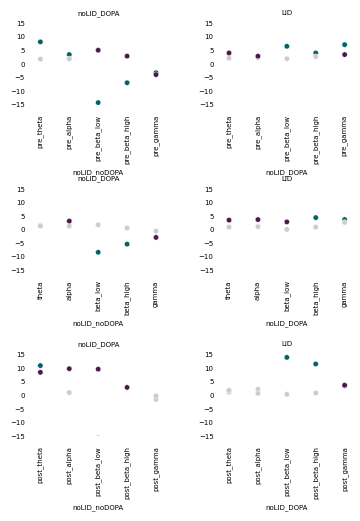

In [40]:
# plot
c_STN    = "#006466ff"
c_CORTEX = "#4d194dff"


plt = utils_plotting.get_figure_template()

ax1 = plt.subplot2grid((77, 66), (0, 0) , colspan=15, rowspan=10)
ax3 = plt.subplot2grid((77, 66), (0, 22), colspan=15, rowspan=10)

ax4 = plt.subplot2grid((77, 66), (20, 0) , colspan=15, rowspan=10)
ax6 = plt.subplot2grid((77, 66), (20, 22), colspan=15, rowspan=10)

ax7 = plt.subplot2grid((77, 66), (40, 0) , colspan=15, rowspan=10)
ax9 = plt.subplot2grid((77, 66), (40, 22), colspan=15, rowspan=10)

ax1 = plot_tstats_by_band(LMM_LFP_results_pre_event  , 'noLID_noDOPA', 'noLID_DOPA', c_STN, ax1)
ax3 = plot_tstats_by_band(LMM_LFP_results_pre_event  , 'noLID_DOPA'  , 'LID'       , c_STN, ax3)
ax1 = plot_tstats_by_band(LMM_ECOG_results_pre_event , 'noLID_noDOPA', 'noLID_DOPA', c_CORTEX, ax1)
ax3 = plot_tstats_by_band(LMM_ECOG_results_pre_event , 'noLID_DOPA'  , 'LID'       , c_CORTEX, ax3)

ax4 = plot_tstats_by_band(LMM_LFP_results_event      , 'noLID_noDOPA', 'noLID_DOPA', c_STN, ax4)
ax6 = plot_tstats_by_band(LMM_LFP_results_event      , 'noLID_DOPA'  , 'LID'       , c_STN, ax6)
ax4 = plot_tstats_by_band(LMM_ECOG_results_event     , 'noLID_noDOPA', 'noLID_DOPA', c_CORTEX, ax4)
ax6 = plot_tstats_by_band(LMM_ECOG_results_event     , 'noLID_DOPA'  , 'LID'       , c_CORTEX, ax6)

ax7 = plot_tstats_by_band(LMM_LFP_results_post_event , 'noLID_noDOPA', 'noLID_DOPA', c_STN, ax7)
ax9 = plot_tstats_by_band(LMM_LFP_results_post_event , 'noLID_DOPA'  , 'LID'       , c_STN, ax9)
ax7 = plot_tstats_by_band(LMM_ECOG_results_post_event, 'noLID_noDOPA', 'noLID_DOPA', c_CORTEX, ax7)
ax9 = plot_tstats_by_band(LMM_ECOG_results_post_event, 'noLID_DOPA'  , 'LID'       , c_CORTEX, ax9)

plt.savefig(DATA_IO.path_figure + "LME_PSD_results.svg", dpi=1200)

# 4. PLOTTING-PSD

In [3]:
# load PSD dataframe
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")
ECOG_PSD_ipsilateral   = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="ipsilateral")

# load MNI Coordinates of ECoG channels
MNI_ECoG_channels      = pd.read_pickle(DATA_IO.path_coordinates + "MNI_ECoG_channels.pkl")

# Define Cortical Parcellation
ECOG_PSD_controlateral_motor      = utils_psd.select_ECoG_PSD_based_on_cortical_parcellation(ECOG_PSD_controlateral, MNI_ECoG_channels, cortical_region="Motor cortex")
ECOG_PSD_controlateral_sensory    = utils_psd.select_ECoG_PSD_based_on_cortical_parcellation(ECOG_PSD_controlateral, MNI_ECoG_channels, cortical_region="Sensory cortex")
ECOG_PSD_controlateral_prefrontal = utils_psd.select_ECoG_PSD_based_on_cortical_parcellation(ECOG_PSD_controlateral, MNI_ECoG_channels, cortical_region="Prefrontal cortex")
ECOG_PSD_controlateral_parietal   = utils_psd.select_ECoG_PSD_based_on_cortical_parcellation(ECOG_PSD_controlateral, MNI_ECoG_channels, cortical_region="Parietal cortex")

In [4]:
ECOG_PSD_controlateral = utils_io.load_ECoG_event_PSD(event_category="tapping", event_laterality="controlateral")
ECOG_PSD               = pd.DataFrame()

for severity in ECOG_PSD_controlateral.keys():
    ECOG_PSD = pd.concat([ECOG_PSD, ECOG_PSD_controlateral[severity]], ignore_index=True)

ECOG_PSD['severity']  = ECOG_PSD['dyskinesia_arm']
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] < 30)  & (ECOG_PSD['dyskinesia_arm'] == "none"), 'severity'] = 'noLID_noDOPA'
ECOG_PSD.loc[(ECOG_PSD['event_start_time'] >= 30) & (ECOG_PSD['dyskinesia_arm'] == "none"), 'severity'] = 'noLID_DOPA'
ECOG_PSD.loc[(ECOG_PSD['dyskinesia_arm'] != "none"), 'severity'] = 'LID'

features = ['pre_event_theta_mean', 'pre_event_alpha_mean', 'pre_event_beta_low_mean','pre_event_beta_high_mean','pre_event_gamma_mean',
            'event_theta_mean', 'event_alpha_mean', 'event_beta_low_mean','event_beta_high_mean','event_gamma_mean',
            'post_event_theta_mean', 'post_event_alpha_mean', 'post_event_beta_low_mean','post_event_beta_high_mean','post_event_gamma_mean',
            "severity","patient"]

ECOG_PSD[features].to_csv(DATA_IO.path_events + "ECOG_PSD.csv")

print("NoLID NoDOPA patients : " + str(ECOG_PSD_controlateral["noLID_noDOPA"].patient.nunique()))
print("NoLID DOPA patients   : " + str(ECOG_PSD_controlateral["noLID_DOPA"].patient.nunique()))
print("LID patients          : " + str(ECOG_PSD_controlateral["LID"].patient.nunique()))

NoLID NoDOPA patients : 10
NoLID DOPA patients   : 9
LID patients          : 8


## 1.1 All Channels

<Figure size 640x480 with 0 Axes>

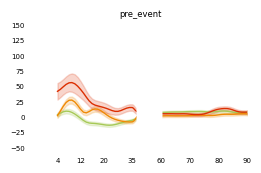

<Figure size 640x480 with 0 Axes>

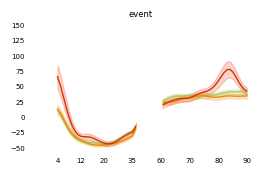

<Figure size 640x480 with 0 Axes>

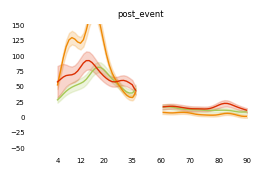

In [15]:
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral, averaging="mean", vmin=-50, vmax=150, segment="pre_event", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/all_channels_for_pre_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral, averaging="mean", vmin=-50, vmax=150, segment="event", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/all_channels_for_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral, averaging="mean", vmin=-50, vmax=150, segment="post_event", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/all_channels_for_post_event_segment")

## 1.2 Mortor Cortex

In [ ]:
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_motor, segment="pre_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//motor_cortex_channels_for_pre_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_motor, segment="event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//motor_cortex_channels_for_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_motor, segment="post_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/motor_cortex_channels_for_post_event_segment")

## 1.3 Sensory Cortex

In [ ]:
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_sensory, segment="pre_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//sensory_cortex_channels_for_pre_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_sensory, segment="event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//sensory_cortex_channels_for_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_sensory, segment="post_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/sensory_cortex_channels_for_post_event_segment")

## 1.4 Prefrontal Cortex

In [ ]:
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_prefrontal, segment="pre_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//prefrontal_cortex_channels_for_pre_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_prefrontal, segment="event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//prefrontal_cortex_channels_for_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_prefrontal, segment="post_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/prefrontal_cortex_channels_for_post_event_segment")

## 1.5 Parietal Cortex

In [ ]:
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_parietal, segment="pre_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//parietal_cortex_channels_for_pre_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_parietal, segment="event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral//parietal_cortex_channels_for_event_segment")
utils_plotting_psd.plot_LID_severity_psd(ECOG_PSD_controlateral_parietal, segment="post_event", dyskinesia_strategy="dyskinesia_arm", error_type="se", 
                                         figure_name=DATA_IO.path_figure + "ECoG-PSD/controlateral/parietal_cortex_channels_for_post_event_segment")